In [2]:
from numpy import linalg as LA
import numpy as np
import pandas as pd
import math
import networkx as nx
import community
import community.community_louvain as community_louvain
import matplotlib.pyplot as plt
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

In [3]:
import rpy2.robjects as robjects
import rpy2.robjects.numpy2ri

r = robjects.r
rpy2.robjects.numpy2ri.activate()

#importr("data.table")

newfunc = r.source("libClusteringGiadaMarsiliFast.R")
aggregateClusters=robjects.globalenv["aggregateClusters"]

R[write to console]: data.table 1.14.2 using 1 threads (see ?getDTthreads).  Latest news: r-datatable.com

R[write to console]: **********
This installation of data.table has not detected OpenMP support. It should still work but in single-threaded mode.
This is a Mac. Please read https://mac.r-project.org/openmp/. Please engage with Apple and ask them for support. Check r-datatable.com for updates, and our Mac instructions here: https://github.com/Rdatatable/data.table/wiki/Installation. After several years of many reports of installation problems on Mac, it's time to gingerly point out that there have been no similar problems on Windows or Linux.
**********



## Louvain clustering

In [4]:
def aggregateClusters_(R,aggregateClusters=aggregateClusters):
    """Slight modification to the original function taken from "libClusteringGiadaMarsiliFast.R" package.
    The modification is made in order to simplify the use and to produce the output with the same format as
    the previous clustering method"""
    C = R.corr()
    intermediate_result = aggregateClusters(C.values)
    nb_clusters = len(intermediate_result[3])
    ls_dfs = []
    for i in range(nb_clusters):
        df = pd.DataFrame(np.array(intermediate_result[3][i]),columns = ['Stock Name'])
        df['Cluster'] = i
        ls_dfs.append(df)
    df = pd.concat(ls_dfs)
    df['StockName'] = R.columns
    df = df.reset_index()
    df = df.drop(columns = 'index')
    df = df.drop(columns = 'Stock Name')
    df = df.rename({0: 'Cluster'},axis = 'columns')
    df = df.set_index('StockName')

    return df



def compute_C_minus_C0(lambdas,v,lambda_plus):
    N=len(lambdas)
    C_clean=np.zeros((N, N))
    
    v_m=np.matrix(v)
    
    # TO CHECK: WHY N-1?!?!? isn't range enough to stop at N-1?!
    # _s stands for _structure below: 
    for i in range(N-1):
        if lambdas[i]>lambda_plus:
            C_clean=C_clean+lambdas[i] * np.dot(v_m[:,i],v_m[:,i].T)  
    return C_clean    

def LouvainCorrelationClustering(R):   # R is a matrix of return
    
    N=R.shape[1]
    T=R.shape[0]

    q=N*1./T
    lambda_plus=(1.+np.sqrt(q))**2

    C=R.corr()
    lambdas, v = LA.eigh(C)

    order = np.argsort(lambdas)
    lambdas,v = lambdas[order],v[:,order]
      
    C_s=compute_C_minus_C0(lambdas,v,lambda_plus)
    mygraph= nx.from_numpy_matrix(np.abs(C_s))
    partition = community.community_louvain.best_partition(mygraph)
    DF=pd.DataFrame.from_dict(partition,orient="index")
    DF['StockName'] = R.columns
    DF = DF.reset_index()
    DF = DF.drop(columns = 'index')
    DF = DF.rename({0: 'Cluster'},axis = 'columns')
    DF = DF.set_index('StockName')
    
    return(DF)


def drop_nans(df,limit = 0.5):
    """given a dataframe and a limit value, first drops all the columns that have
    more than limit % nans than drops all raws containing at least one nan value"""
    row_num = df.shape[0]
    nan_col = df.isnull().sum(axis=0)>(row_num*limit)
    df=df.drop(columns=df.columns[nan_col])
    return df.dropna()

def pick_n_from_k(df,n,seed = 0,onlynames = False):
    """given a dataframe and a number N, returns a dataframe that 
    contains n randomly selected columns of the input dataframe"""
    
    k = df.shape[0]
    
    #safety check
    assert k >= n, 'K should be >= N'
    
    #if onlynames is active return only the name of the columns
    if onlynames:
        random.seed(seed)
        return random.sample(list(df.columns), n)
    return df.sample(n=n, random_state=seed, axis='columns')

def bootstrap_CI(data, nbr_draws):
    """Given an array and a number of random samples performs bootstrapping to
    find the confidence intervals of the mean"""
    # Input: your array and the number of random samples (e.g., 1000 is a good number)
    # Output: [lower error, upper error]

    means = np.zeros(nbr_draws)
    data = np.array(data)

    for n in range(nbr_draws):
        indices = np.random.randint(0, len(data), len(data))
        data_tmp = data[indices] 
        means[n] = np.nanmean(data_tmp)

    return [np.nanpercentile(means, 0.5),np.nanpercentile(means, 99.5)]

def optimalWeights(df,verbose = False,shortBan = True):
    """use pypfopt to compute the optimal weights of the portfolio following markovitz strategy"""
    mu = expected_returns.mean_historical_return(df,returns_data=True,log_returns =True)
    S = risk_models.sample_cov(df,returns_data=True,log_returns =True)
    if shortBan:
        #By default the ef is long only 
        ef = EfficientFrontier(mu, S)
    else:
        #Allow negative weights => No shortBan
        ef = EfficientFrontier(mu, S, weight_bounds=(-1, 1))
    #We could limit the maxweight just by changing the bounds ex: max 10% with shortban weight_bounds=(0, 0.1)
    raw_weights = ef.max_sharpe()
    cleaned_weights = ef.clean_weights()
    if verbose:
        return ef.portfolio_performance(verbose=False)
    return cleaned_weights

def weight_inverse_std(df):
    """Helper function for the inner-cluster aggregation using inverse std technique.
    Given a df containing all data of a cluster rescale the value of returns of each stock
    taking as weight the sum(std)/std then aggregate all the returns toghether. 
    The following methods will use this portfolio of clustered stocks as a single 
    stock and compose a portfolio"""
    sum_stds = 0
    cluster = df['Cluster'].iloc[0]
    df = df.drop(columns = ['Cluster']).transpose()
    for col in df.columns:
        if col != 'Cluster':
            sum_stds += df[col].std()
    for col in df.columns:
        if col != 'Cluster':
            df[col] = df[col]*sum_stds/df[col].std()
    df = df.sum(axis = 1)
    df = df.transpose()
    df['Cluster'] = cluster
    #df = df.transpose()
    return df

def compute_clusters_returns(df,clusters,intra_cluster_strategy = 'equal weight'):
    """given a dataframe and his clusters compute the clusters means"""
    
    if intra_cluster_strategy == 'equal weight':
        means = df.transpose()
        means = pd.merge(means, clusters,left_index = True, right_on='StockName')
        means = means.groupby('Cluster').mean().transpose()
    elif intra_cluster_strategy == 'inverse std':
        #TO DO: test this method
        dftr = df.transpose()
        dftr = pd.merge(dftr, clusters,left_index = True, right_on='StockName')
        means = dftr.groupby('Cluster').apply(lambda x: weight_inverse_std(x))
        means = means.drop(columns = ['Cluster']).transpose()
    return means

def compute_portfolio_return(df,clustering = 'louvian',inter_cluster_strategy ='equal weight',intra_cluster_strategy = 'equal weight'):
    """given a dataframe, a clustering method and a portfolio weighting strategy
    compute the return of the portfolio composed by appling clustering than combining
    the clusters using the strategy"""
    if inter_cluster_strategy == 'equal weight':
        
        if clustering == 'louvian':
            clusters = LouvainCorrelationClustering(df)
            
        elif clustering == 'GiadaMarsili':
            clusters = aggregateClusters_(df)
            
        cluster_means = compute_clusters_returns(df,clusters,intra_cluster_strategy)
        portfolio_mean = cluster_means.mean().mean()
        portfolio_std = cluster_means.mean(axis = 1).std()
        portfolio_std = np.exp((portfolio_std)*252)-1
        portfolio_mean = np.exp((portfolio_mean)*252)-1
        SharpR = portfolio_mean/portfolio_std
        return portfolio_mean,portfolio_std,SharpR
        
    elif inter_cluster_strategy == 'inverse std':
        
        if clustering == 'louvian':
            clusters = LouvainCorrelationClustering(df)
            
        elif clustering == 'GiadaMarsili':
            clusters = aggregateClusters_(df)
               
        cluster_means = compute_clusters_returns(df,clusters,intra_cluster_strategy)
        cluster_std = cluster_means.std()
        weights = np.array([ i/sum(list(cluster_std)) for i in list(cluster_std)]).T
        # I dont know if I can do the mean before or not maybe it changes if variables are dependent
        portfolio_mean = (np.array(cluster_means)@weights).mean()
        portfolio_std = (np.array(cluster_means)@weights).std()
        portfolio_std = np.exp((portfolio_std)*252)-1
        portfolio_mean = np.exp((portfolio_mean)*252)-1
        SharpR = portfolio_mean/portfolio_std
        return portfolio_mean,portfolio_std,SharpR
        
    elif inter_cluster_strategy == 'markovitz':
        if clustering == 'NO clustering':
            #no clustering only markovitz portfolio
            portfolio_mean, portfolio_std, SharpR = optimalWeights(df,verbose = True)
            return portfolio_mean,portfolio_std,SharpR
        
        elif clustering == 'louvian':
            clusters = LouvainCorrelationClustering(df)
            
        elif clustering == 'GiadaMarsili':
            clusters = aggregateClusters_(df)
    
        cluster_means = compute_clusters_returns(df,clusters,intra_cluster_strategy)
        portfolio_mean, portfolio_std, SharpR = optimalWeights(df,verbose = True)
        return portfolio_mean,portfolio_std,SharpR
             
def compute_stategy_avg_return(df,n,n_picks,clustering = 'louvian',inter_cluster_strategy ='equal weight',intra_cluster_strategy = 'equal weight'):
    """given a dataframe, a number of picks, a size n, a clustering method and a portfolio weighting strategy
    compute the average return of n_picks portfolios composed picking at random n stocks from the df,
    applying clustering and combining with the weight strategy"""
    portfolio_returns = []
    portfolio_risks = []
    portfolio_sharpRs = []
    for i in range(n_picks):
        sub_df = pick_n_from_k(df,n,seed = (i+1))
        portfolio_return,portfolio_risk,SharpR = compute_portfolio_return(sub_df,clustering = clustering,inter_cluster_strategy =inter_cluster_strategy,intra_cluster_strategy = intra_cluster_strategy)
        print('portfolio nb: ',i, 'return: ',portfolio_return)
        portfolio_returns.append(portfolio_return)
        portfolio_risks.append(portfolio_risk)
        portfolio_sharpRs.append(SharpR)
    portfolio_returns_mean = sum(portfolio_returns)/len(portfolio_returns)
    CI = bootstrap_CI(portfolio_returns,int(n_picks/1.5))
    yerr = [-(CI[0]-portfolio_returns_mean),CI[1]-portfolio_returns_mean]
    plt.errorbar(1,portfolio_returns_mean,yerr = np.array(yerr).reshape(2,1), fmt='.', ecolor = 'red')
    plt.ylabel("Mean return of clustering method :" + clustering +' intra ' + intra_cluster_strategy +' inter ' + inter_cluster_strategy)
    plt.title("Mean return of clustering method with confidence intervals")
    return portfolio_returns,portfolio_risks,portfolio_sharpRs

## Performance Analysis

In [5]:
DF=pd.read_parquet("us_equities_logreturns.parquet")
DF = drop_nans(DF)

portfolio nb:  0 return:  0.1200007601897759
portfolio nb:  1 return:  0.1210891337400457
portfolio nb:  2 return:  0.13217982253269867
portfolio nb:  3 return:  0.12075074630855243
portfolio nb:  4 return:  0.113156204822352
portfolio nb:  5 return:  0.129663231149026
portfolio nb:  6 return:  0.12997140107012228
portfolio nb:  7 return:  0.1271659731690855
portfolio nb:  8 return:  0.12404976857314343
portfolio nb:  9 return:  0.12097813708065197
strategy mean:  ([0.1200007601897759, 0.1210891337400457, 0.13217982253269867, 0.12075074630855243, 0.113156204822352, 0.129663231149026, 0.12997140107012228, 0.1271659731690855, 0.12404976857314343, 0.12097813708065197], [16.414386701561753, 19.91652113376373, 15.80519976197714, 15.540594597651989, 16.60782293505139, 15.492068142889181, 17.18747481166097, 16.68463314159112, 16.020282323087237, 16.86563394556452], [0.007310706295128187, 0.006079833567658954, 0.008363059279433222, 0.007770020995644306, 0.006813427940849001, 0.0083696527767043

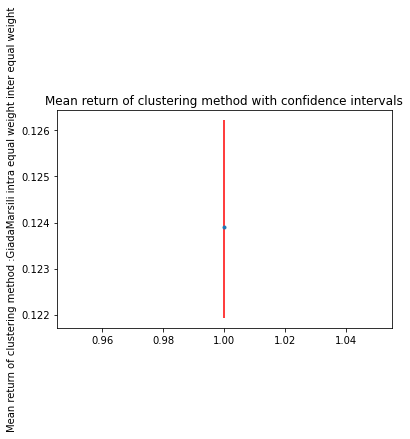

In [6]:
print('strategy mean: ',compute_stategy_avg_return(DF,65,10,clustering = 'GiadaMarsili'))

portfolio nb:  0 return:  0.12461577718405947
portfolio nb:  1 return:  0.11914580532428087
portfolio nb:  2 return:  0.14156995182531262
portfolio nb:  3 return:  0.13538660731143448
portfolio nb:  4 return:  0.1296094202074658
portfolio nb:  5 return:  0.134883335237447
portfolio nb:  6 return:  0.1353595711686839
portfolio nb:  7 return:  0.13231161538231873
portfolio nb:  8 return:  0.1341344234730848
portfolio nb:  9 return:  0.1308447821469192
strategy inv std:  ([0.12461577718405947, 0.11914580532428087, 0.14156995182531262, 0.13538660731143448, 0.1296094202074658, 0.134883335237447, 0.1353595711686839, 0.13231161538231873, 0.1341344234730848, 0.1308447821469192], [15.350836516530666, 16.27426582462073, 14.359912732167555, 13.632121163894292, 14.175142818786213, 13.566603102032044, 13.476572920689724, 14.809355446393951, 13.747869233520255, 14.682559919808948], [0.00811784928136431, 0.007321117069627167, 0.009858691655429257, 0.009931441019613015, 0.009143429584052966, 0.0099423

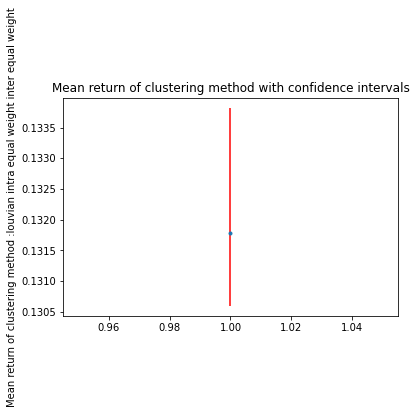

In [7]:
print('strategy inv std: ',compute_stategy_avg_return(DF,65,10,inter_cluster_strategy ='equal weight',clustering = 'louvian',intra_cluster_strategy = 'equal weight'))

portfolio nb:  0 return:  0.12637960062385645
portfolio nb:  1 return:  0.11810844826063782
portfolio nb:  2 return:  0.14156995182531262
portfolio nb:  3 return:  0.13530448526501915
portfolio nb:  4 return:  0.13108164630015584
portfolio nb:  5 return:  0.134883335237447
portfolio nb:  6 return:  0.1353595711686839
portfolio nb:  7 return:  0.13231161538231873
portfolio nb:  8 return:  0.13360769771236214
portfolio nb:  9 return:  0.1308447821469192
strategy mean:  ([0.12637960062385645, 0.11810844826063782, 0.14156995182531262, 0.13530448526501915, 0.13108164630015584, 0.134883335237447, 0.1353595711686839, 0.13231161538231873, 0.13360769771236214, 0.1308447821469192], [14.722878754349018, 16.487439128717295, 14.359912732167555, 13.796985414852893, 14.436617859268791, 13.566603102032044, 13.476572920689724, 14.809355446393951, 13.77111132906707, 14.682559919808948], [0.008583891963827044, 0.007163541125978764, 0.009858691655429257, 0.009806815126394175, 0.009079803010508937, 0.00994

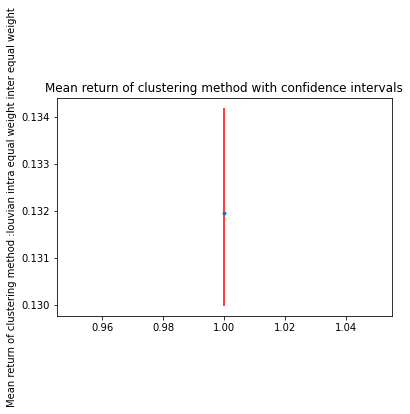

In [8]:
print('strategy mean: ',compute_stategy_avg_return(DF,65,10,inter_cluster_strategy ='equal weight',clustering = 'louvian',intra_cluster_strategy = 'equal weight'))

portfolio nb:  0 return:  0.12637960062385645
portfolio nb:  1 return:  0.12323792359717722
portfolio nb:  2 return:  0.14156995182531262
portfolio nb:  3 return:  0.13538660731143448
portfolio nb:  4 return:  0.13108164630015584
portfolio nb:  5 return:  0.134883335237447
portfolio nb:  6 return:  0.1353595711686839
portfolio nb:  7 return:  0.13231161538231873
portfolio nb:  8 return:  0.1341344234730848
portfolio nb:  9 return:  0.1308447821469192
strategy mean:  ([0.12637960062385645, 0.12323792359717722, 0.14156995182531262, 0.13538660731143448, 0.13108164630015584, 0.134883335237447, 0.1353595711686839, 0.13231161538231873, 0.1341344234730848, 0.1308447821469192], [14.722878754349018, 16.49174645059412, 14.359912732167555, 13.632121163894292, 14.436617859268791, 13.566603102032044, 13.476572920689724, 14.809355446393951, 13.74786923352025, 14.682559919808948], [0.008583891963827044, 0.007472703025502647, 0.009858691655429257, 0.009931441019613015, 0.009079803010508937, 0.00994230

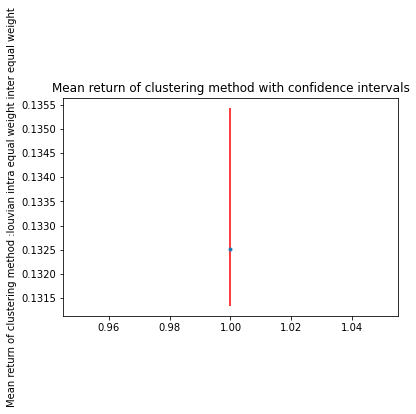

In [9]:
print('strategy mean: ',compute_stategy_avg_return(DF,65,10,inter_cluster_strategy ='equal weight',clustering = 'louvian',intra_cluster_strategy = 'equal weight'))

## Cluster Analysis

In [ ]:
DF=pd.read_parquet("us_equities_logreturns.parquet")

DF_cut=DF.iloc[-5000:]

sel=DF_cut.isnull().sum(axis=0)>0
DF_cut=DF_cut.drop(columns=DF_cut.columns[sel])
